# Prix Carburant

In [1]:
#!python -m venv .venv
#!source .venv/bin/activate
#!pip install pandas
#!python -m ipykernel install --name indirect-taxation-kernel --user

In [2]:
import pandas as pd
import zipfile
import os
from urllib.request import urlretrieve
from datetime import date

In [3]:
# Si il y a déjà des fichiers avec ces noms, le script ne les remplaces pas, donc il faut les suprimer au debut.
os.remove("prix_mensuel_carburant.csv")
os.remove("prix_annuel_carburant.csv")

In [4]:
carburants = {"diesel":"000442588",
              "super_98":"000442589",
             "super_95":"000849411",
             "super_plombe":"000442587",
             "super_95_e10":"010596132"}  ##le 95_e10 j'ai repris l'écriture de l'IPP, mais à voir si c'est pas juste super_e10

In [5]:
def get_df(carburant,id_url):
    path_to_zip_file =f"/tmp/{carburant}.zip"
    urlretrieve(f"https://www.insee.fr/fr/statistiques/serie/telecharger/csv/{id_url}?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1992&periodeFin={date.today().month}&anneeFin={date.today().year}&revision=sansrevisions", path_to_zip_file)
    directory_to_extract_to = "/tmp"
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
    df = pd.read_csv("/tmp/valeurs_mensuelles.csv", sep=";")
    return df

In [6]:
def clean_df(carburant,df):
    df.columns = ['date', f'{carburant}_ttc', 'codes']
    df = df.dropna(subset = ['codes'])
    del df['codes']
    df['date'] = df['date'].astype(str) + '-01'
    return df

In [7]:
df_mens = pd.DataFrame({'date':["1992-01-01"]})
for carburant, id_url in carburants.items():
        df = get_df(carburant,id_url)
        df_clean = clean_df(carburant,df)
        df_mens = df_mens.merge(df_clean, on=['date','date'], how='outer')
        df_mens.sort_values(by='date',ascending = False, inplace= True)
        
df_mens.to_csv("prix_mensuel_carburant.csv", index=False, index_label=False)

/tmp/ipykernel_395451/3498542900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype(str) + '-01'
/tmp/ipykernel_395451/3498542900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype(str) + '-01'
/tmp/ipykernel_395451/3498542900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [8]:
df_mens

date diesel_ttc super_98_ttc super_95_ttc super_plombe_ttc  \
0    2023-08-01       1.85         1.99         1.94              NaN   
1    2023-07-01       1.72         1.91         1.85              NaN   
2    2023-06-01        1.7         1.94         1.88              NaN   
3    2023-05-01       1.69         1.93         1.87              NaN   
4    2023-04-01       1.81          2.0         1.95              NaN   
..          ...        ...          ...          ...              ...   
375  1992-05-01       0.54         0.78          NaN             0.81   
376  1992-04-01       0.53         0.77          NaN             0.81   
377  1992-03-01       0.54         0.77          NaN             0.81   
378  1992-02-01       0.54         0.78          NaN             0.81   
379  1992-01-01       0.54         0.78          NaN              0.8   

    super_95_e10_ttc  
0               1.93  
1               1.84  
2               1.86  
3               1.85  
4               1.93  
..               ...  
375              NaN  
376              NaN  
377              NaN  
378              NaN  
379              NaN  

[380 rows x 6 columns]

In [9]:
df_mens[['annee','mois','jour']] = df_mens['date'].str.split('-',expand=True)
df_mens.drop(['date','mois','jour'], axis=1, inplace=True)
df_mens['diesel_ttc'] = pd.to_numeric(df_mens['diesel_ttc'])
df_mens['super_98_ttc'] = pd.to_numeric(df_mens['super_98_ttc'])
df_mens['super_95_ttc'] = pd.to_numeric(df_mens['super_95_ttc'])
df_mens['super_plombe_ttc'] = pd.to_numeric(df_mens['super_plombe_ttc'])
df_mens['super_95_e10_ttc'] = pd.to_numeric(df_mens['super_95_e10_ttc'])

In [10]:
df_mens.describe()
df_mens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   diesel_ttc        380 non-null    float64
 1   super_98_ttc      380 non-null    float64
 2   super_95_ttc      260 non-null    float64
 3   super_plombe_ttc  157 non-null    float64
 4   super_95_e10_ttc  56 non-null     float64
 5   annee             380 non-null    object 
dtypes: float64(5), object(1)
memory usage: 17.9+ KB


In [11]:
df_ann = df_mens.groupby(['annee']).agg({'diesel_ttc': ['mean'],'super_98_ttc': ['mean'],
                                         'super_95_ttc': ['mean'],'super_plombe_ttc': ['mean'],
                                         'super_95_e10_ttc': ['mean']}).round(2)

In [12]:
df_ann.to_csv("prix_annuel_carburant.csv")
df_ann = pd.read_csv("prix_annuel_carburant.csv", sep=",")
os.remove("prix_annuel_carburant.csv")
df_ann = df_ann.iloc[2:, :]
df_ann = df_ann.rename(columns={'Unnamed: 0': 'date'})
df_ann.to_csv("prix_annuel_carburant.csv", index=False, index_label=False)

In [13]:
df_ann

date diesel_ttc super_98_ttc super_95_ttc super_plombe_ttc  \
2   1992       0.54         0.78          NaN             0.81   
3   1993       0.56         0.79          NaN             0.84   
4   1994        0.6         0.82          NaN             0.87   
5   1995       0.59         0.87          NaN              0.9   
6   1996       0.66         0.92          NaN             0.96   
7   1997       0.68         0.96          NaN             0.99   
8   1998       0.64         0.93          NaN             0.96   
9   1999       0.69         0.96          NaN             1.01   
10  2000       0.85         1.11          NaN             1.18   
11  2001        0.8         1.05          NaN             1.13   
12  2002       0.77         1.03          1.0              1.1   
13  2003        0.8         1.04         1.02             1.11   
14  2004       0.89         1.09         1.08             1.16   
15  2005       1.03         1.21         1.18             1.24   
16  2006       1.09         1.29         1.25              NaN   
17  2007        1.1         1.32         1.29              NaN   
18  2008       1.28         1.42         1.38              NaN   
19  2009       1.01         1.25         1.22              NaN   
20  2010       1.16          1.4         1.36              NaN   
21  2011       1.34         1.55          1.5              NaN   
22  2012       1.41         1.63         1.59              NaN   
23  2013       1.36          1.6         1.56              NaN   
24  2014        1.3         1.54          1.5              NaN   
25  2015       1.17         1.41         1.37              NaN   
26  2016       1.11         1.35         1.32              NaN   
27  2017       1.23         1.45         1.38              NaN   
28  2018       1.44         1.57         1.51              NaN   
29  2019       1.44         1.56         1.51              NaN   
30  2020       1.27         1.42         1.37              NaN   
31  2021       1.44         1.62         1.56              NaN   
32  2022       1.86         1.88         1.83              NaN   
33  2023        1.8         1.96          1.9              NaN   

   super_95_e10_ttc  
2               NaN  
3               NaN  
4               NaN  
5               NaN  
6               NaN  
7               NaN  
8               NaN  
9               NaN  
10              NaN  
11              NaN  
12              NaN  
13              NaN  
14              NaN  
15              NaN  
16              NaN  
17              NaN  
18              NaN  
19              NaN  
20              NaN  
21              NaN  
22              NaN  
23              NaN  
24              NaN  
25              NaN  
26              NaN  
27              NaN  
28              NaN  
29             1.49  
30             1.35  
31             1.54  
32             1.78  
33             1.88

In [23]:
df_ann.diesel_ttc = df_ann.diesel_ttc.astype(float)
df_ann.super_98_ttc = df_ann.super_98_ttc.astype(float)

<Axes: title={'center': 'Prix annuel du super_98_ttc en euros'}, xlabel='date'>

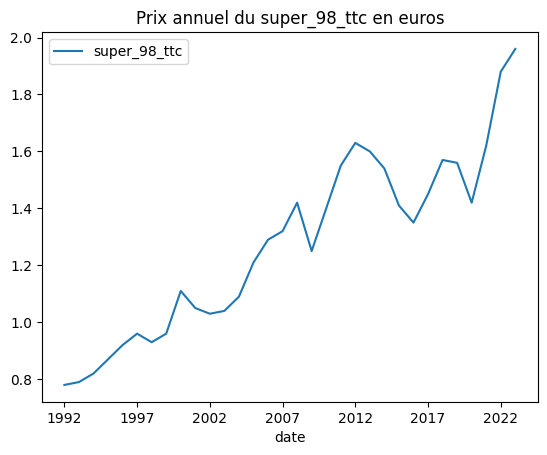

In [26]:
df_ann.diesel_ttc.atype = 'float64'
df_ann.plot.line(x="date", y="super_98_ttc", title="Prix annuel du super_98_ttc en euros")